In [106]:
import pandas as pd
import numpy as np
import os.path
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
list_of_files=glob.glob('./cdips_dell_test/*.txt')
df=pd.read_csv('featuretable.csv')
for i in range(len(list_of_files)):
    word=open(list_of_files[i],'r').read().strip('\n')
    df.loc[df.loc[:,'webpageID']==os.path.basename(list_of_files[i])[:7],'word']=word


df=df.fillna(' ')
df.head()


,webpageID,og:type,pagetype,salestype,categorypath,country,language,label,word
0,000051_,category,category,config_category,deals,us,en,0.0,for hours only get tremendous savings up to o...
1,000075_,product,product,franchise,desktops,us,en,1.0,for hours only get tremendous savings up to o...
2,000087_,category,category,parent_product_category,all-products,us,en,2.0,dell o sign in click to chat or call us shop ...
3,000131_,product,product,franchise,laptops,us,en,3.0,for hours only get tremendous savings up to o...
4,000154_,product,product,franchise,enterprise-products,us,en,4.0,dell o sign in click to chat or call us shop ...


In [108]:
X_train=df.loc[:,'word'].values
y_train=df.loc[:,'label'].astype(int).values

In [124]:
stops=stopwords.words("english")
stops.append('dell')
stops+=['pro', 'internal', 'cm', 'ghz', 'factor', 'mm', 'inside', 'balance',
       'optiplex', 'celeron', 'keyboard', 'bit', 'ssd', 'english', 'vpro',
       'lbs', 'fips', 'itanium', 'double', 'reader']

porter= PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

vectorizer = TfidfVectorizer(analyzer='word',stop_words=stops,use_idf=False,
                             tokenizer=None, norm=None, max_features= 200)
words_features = vectorizer.fit_transform(X_train)

In [125]:
words_features=words_features.toarray()
words_features.shape

(499, 200)

In [126]:
key_words = vectorizer.get_feature_names()
words_count=np.sum(words_features,axis=0)

In [127]:
scores=[]
scores_std=[]
N_trees=[5,10,20,30,40,50,100,150,200]
for n_tree in N_trees:
    randomforest=RandomForestClassifier(n_estimators=n_tree,n_jobs=-1)
    score=cross_val_score(estimator=randomforest,X=words_features,y=y_train,cv=5,n_jobs=-1)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))

/Users/Meng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/Meng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/Meng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/Meng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum 

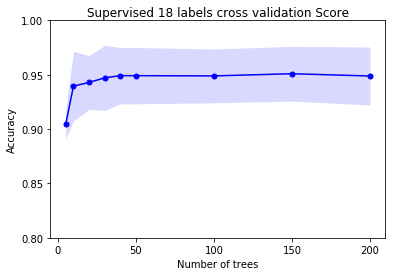

In [137]:
scores=np.array(scores)
scores_std=np.array(scores_std)
plt.plot(N_trees,scores,color='blue',marker='o',markersize='5')
plt.fill_between(N_trees,scores+scores_std,scores-scores_std,alpha=0.15,color='blue')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.title('Supervised 18 labels cross validation Score')
plt.show()

In [129]:
words_features[:,:]

array([[  0.,   0.,   0., ...,   3.,   0.,   0.],
       [  0.,   0.,  10., ...,   3.,   0.,  10.],
       [  0.,   3.,   0., ...,   3.,   2.,   0.],
       ..., 
       [  0.,   1.,   0., ...,   4.,   0.,   0.],
       [  6.,   0.,   0., ...,   7.,   0.,   0.],
       [  0.,   4.,   0., ...,   3.,   3.,   0.]])

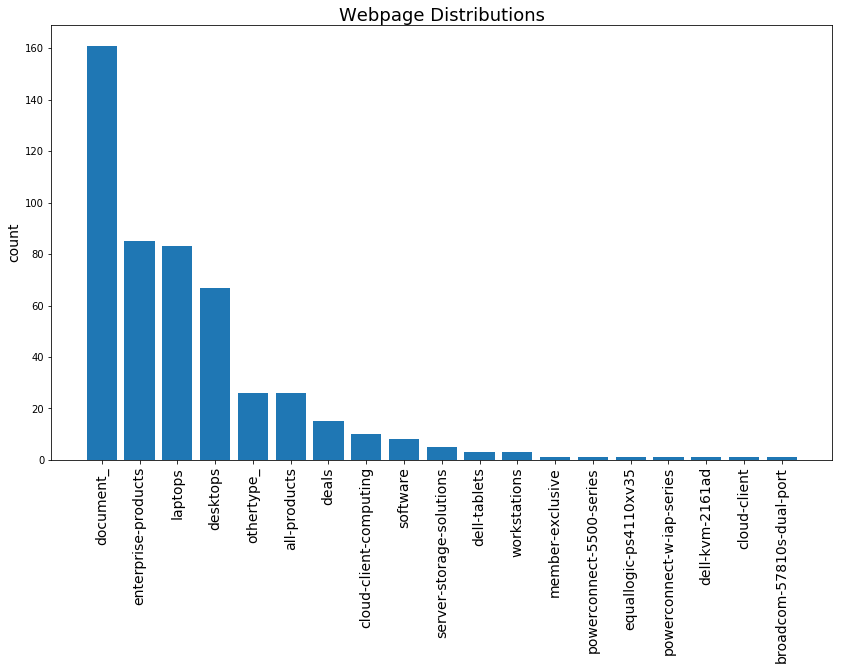

In [130]:
fig=plt.figure(figsize=(14,8))
labels,labelscount = np.unique(df.loc[:,'categorypath'].values,return_counts=True)
indices=np.argsort(labelscount)[::-1]
plt.bar(range(len(labels)),labelscount[indices],align='center')
plt.xticks(range(len(labels)),labels[indices],rotation=90, fontsize=14)
plt.title('Webpage Distributions', fontsize=18)
plt.ylabel('count', fontsize=14)
plt.show()


In [131]:
labeldict={}
for i, j in zip(df.loc[:,'categorypath'],df.loc[:,'label']):
    if j not in labeldict:
        labeldict[j]=i
    if len(labeldict)==len(labels):
        break
labeldict

{0.0: 'deals',
 1.0: 'desktops',
 2.0: 'all-products',
 3.0: 'laptops',
 4.0: 'enterprise-products',
 5.0: 'member-exclusive',
 6.0: 'cloud-client-computing',
 7.0: 'document_',
 8.0: 'server-storage-solutions',
 9.0: 'dell-kvm-2161ad',
 10.0: 'powerconnect-5500-series',
 11.0: 'workstations',
 12.0: 'othertype_',
 13.0: 'broadcom-57810s-dual-port',
 14.0: 'software',
 15.0: 'powerconnect-w-iap-series',
 16.0: 'cloud-client',
 17.0: 'dell-tablets',
 18.0: 'equallogic-ps4110xv35'}

In [132]:
randomforest.fit(words_features,y_train)
importances = randomforest.feature_importances_
indicesword=np.argsort(importances)[::-1]


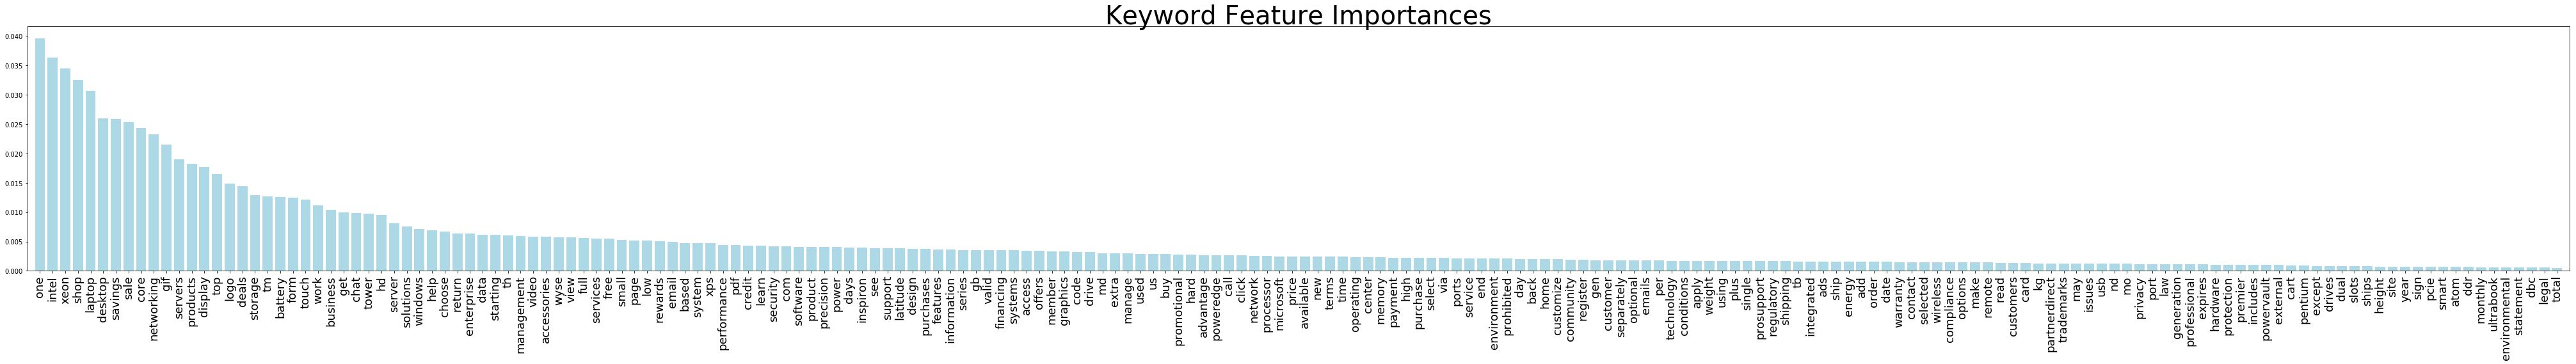

In [133]:
fig=plt.figure(figsize=(56,8))
tmp=200
plt.title('Keyword Feature Importances', fontsize = 40)
plt.bar(range(len(key_words[:tmp])),importances[indicesword][:tmp],color='lightblue',align='center')
plt.xticks(range(len(key_words[:tmp])),np.array(key_words)[indicesword][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


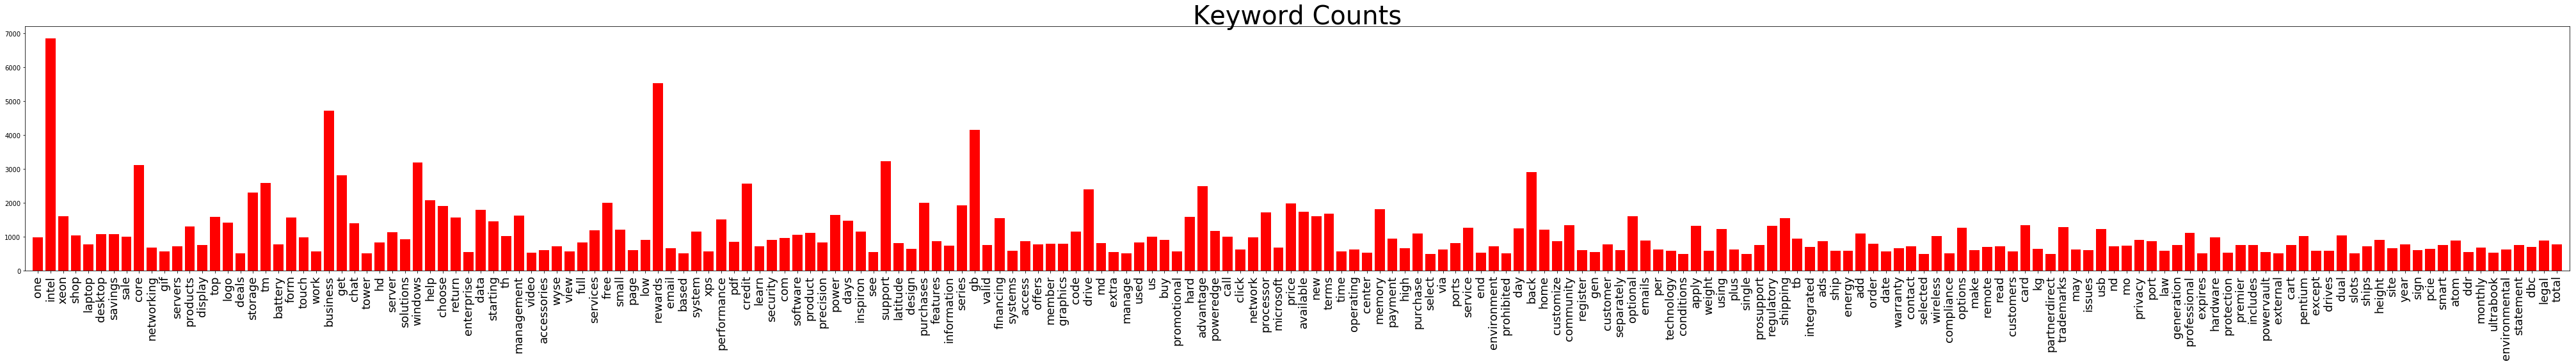

In [134]:
fig=plt.figure(figsize=(56,8))
plt.title('Keyword Counts', fontsize = 40)
plt.bar(range(len(key_words[:tmp])),np.array(words_count)[indicesword][:tmp],color='red',align='center')
plt.xticks(range(len(key_words[:tmp])),np.array(key_words)[indicesword][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


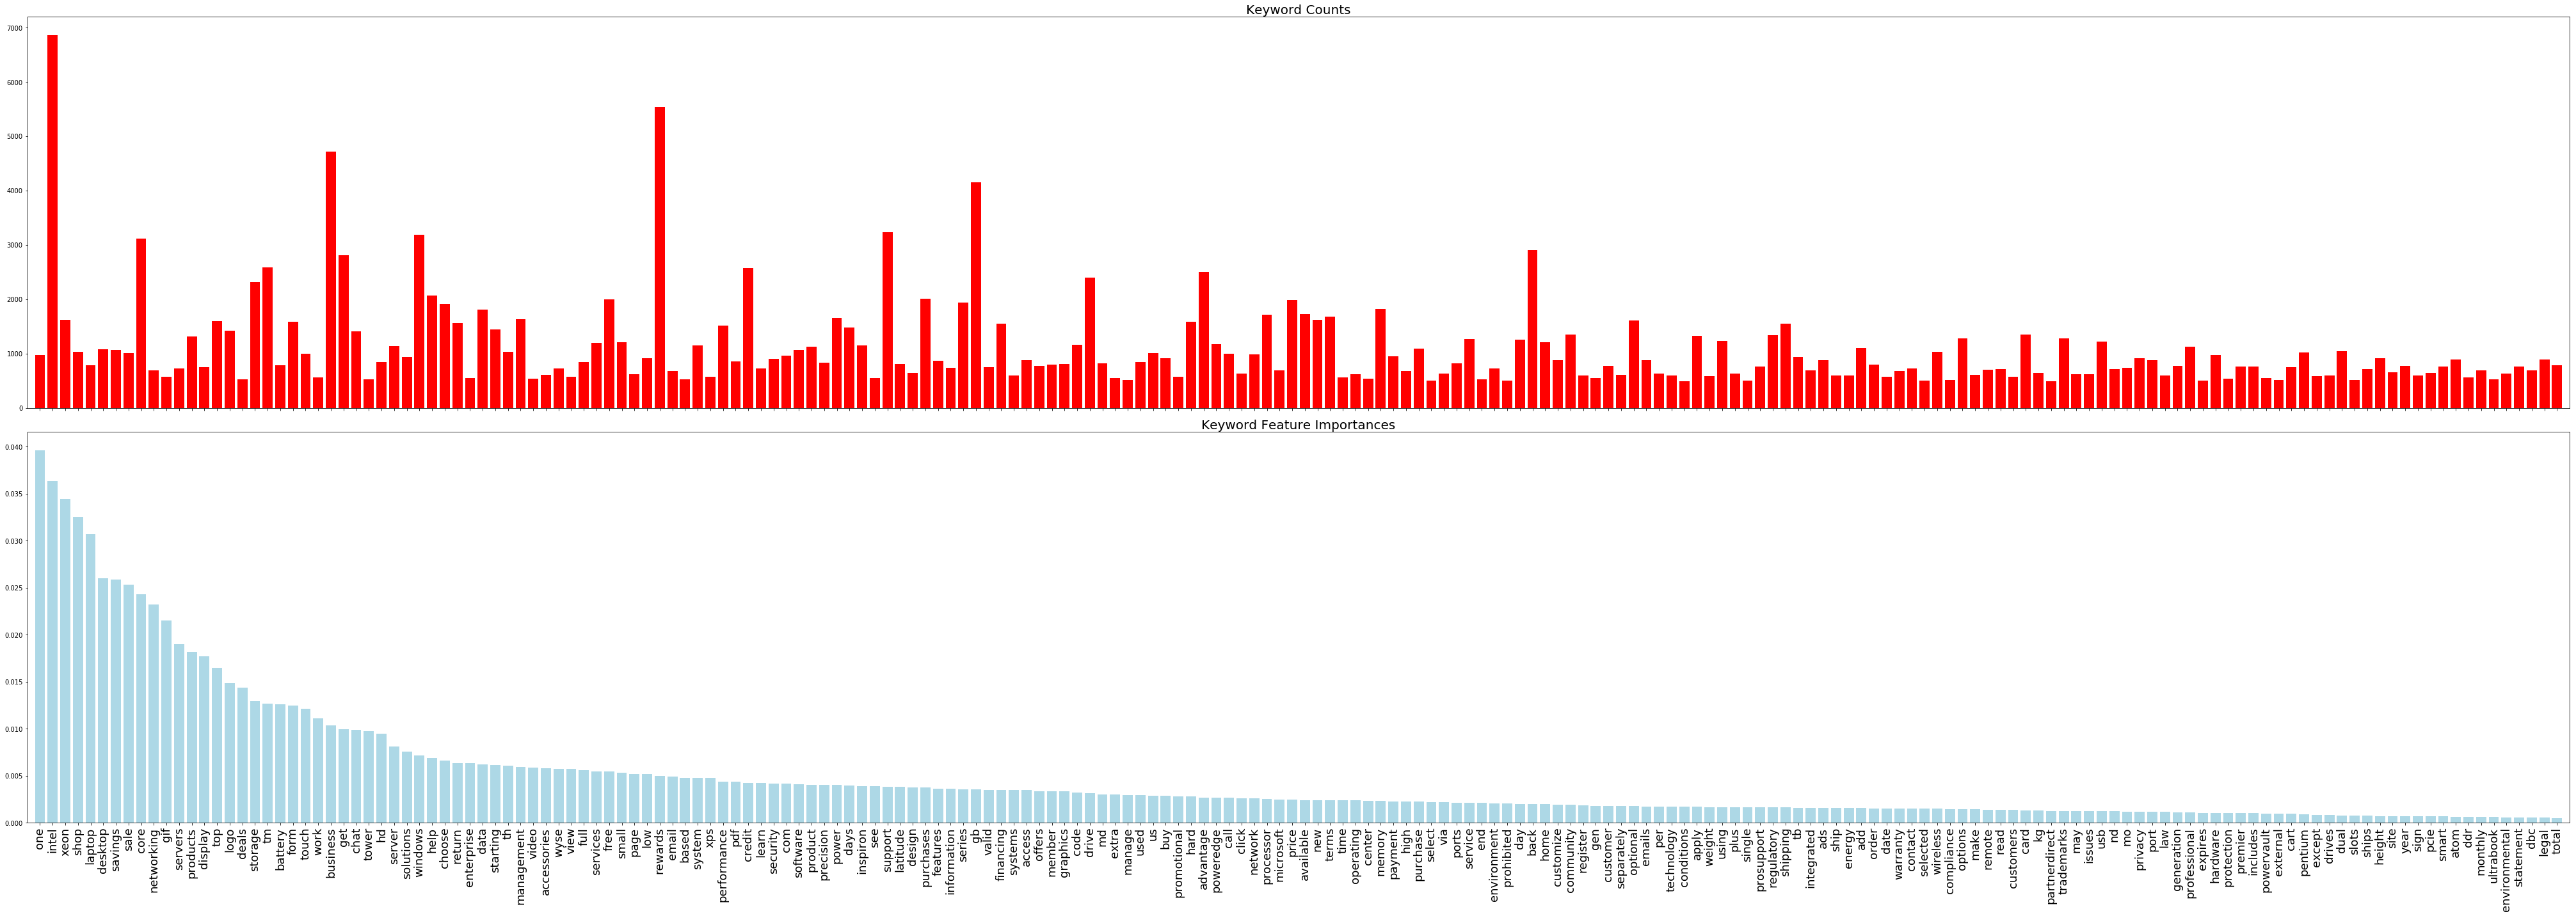

In [135]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(56,20),sharex=True)
ax[1].bar(range(len(key_words[:tmp])),importances[indicesword][:tmp],color='lightblue',align='center')
ax[1].set_title('Keyword Feature Importances', fontsize=20)
ax[0].set_title('Keyword Counts',fontsize=20)
ax[0].bar(range(len(key_words[:tmp])),words_count[indicesword][:tmp],color='red',align='center')
plt.xticks(range(len(key_words[:tmp])),np.array(key_words)[indicesword][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()

In [136]:
np.array(key_words)[indicesword][-20:]

array(['except', 'drives', 'dual', 'slots', 'ships', 'height', 'site',
       'year', 'sign', 'pcie', 'smart', 'atom', 'ddr', 'monthly',
       'ultrabook', 'environmental', 'statement', 'dbc', 'legal', 'total'], 
      dtype='<U13')